In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# So we already have 784 pixels 

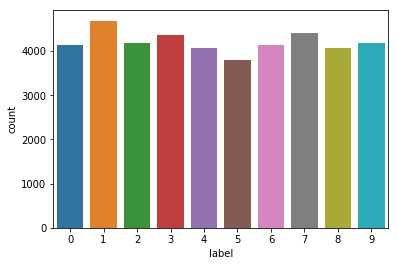

In [6]:
Y_train = train["label"]
X_train = train.drop("label", axis = 1)

del train
sns.countplot(Y_train)

In [7]:
# EDA
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
# Normalization of data
X_train = X_train/255.0
test = test/255.0

In [10]:
# Reshape to 28 X 28 X 1
# 3D tensor
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [11]:
# Label Encoding of the output variable as Softmax works with that
Y_train = to_categorical(Y_train, num_classes = 10)

In [12]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed, )

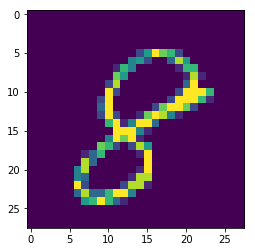

In [13]:
plt.imshow(X_train[0][:,:,0])

## CNN Model 

In [14]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))

model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (28,28,1)))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [15]:
optimizer = Adam(lr = 0.001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# To reduce Learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
epochs = 30
batch_size = 86

In [18]:
# With data augmentation to prevent overfitting 
# It is done for purpose of Rotated Image of Grpahical attributes

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [21]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 9s - loss: 0.1351 - acc: 0.9587 - val_loss: 0.0492 - val_acc: 0.9857
Epoch 2/30
 - 9s - loss: 0.0994 - acc: 0.9704 - val_loss: 0.0408 - val_acc: 0.9862
Epoch 3/30
 - 9s - loss: 0.0826 - acc: 0.9756 - val_loss: 0.0314 - val_acc: 0.9902
Epoch 4/30
 - 9s - loss: 0.0734 - acc: 0.9789 - val_loss: 0.0270 - val_acc: 0.9914
Epoch 5/30
 - 9s - loss: 0.0654 - acc: 0.9807 - val_loss: 0.0416 - val_acc: 0.9881
Epoch 6/30
 - 9s - loss: 0.0627 - acc: 0.9811 - val_loss: 0.0242 - val_acc: 0.9917
Epoch 7/30
 - 9s - loss: 0.0536 - acc: 0.9839 - val_loss: 0.0361 - val_acc: 0.9914
Epoch 8/30
 - 9s - loss: 0.0525 - acc: 0.9845 - val_loss: 0.0322 - val_acc: 0.9902
Epoch 9/30
 - 9s - loss: 0.0506 - acc: 0.9847 - val_loss: 0.0290 - val_acc: 0.9945
Epoch 10/30
 - 9s - loss: 0.0461 - acc: 0.9861 - val_loss: 0.0245 - val_acc: 0.9929
Epoch 11/30
 - 9s - loss: 0.0447 - acc: 0.9865 - val_loss: 0.0232 - val_acc: 0.9938
Epoch 12/30
 - 9s - loss: 0.0446 - acc: 0.9861 - val_loss: 0.0200 - val_acc: 0.9936



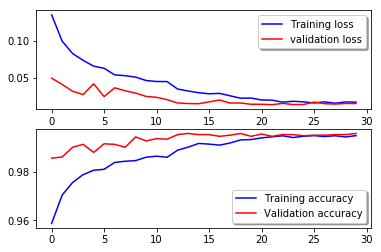

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

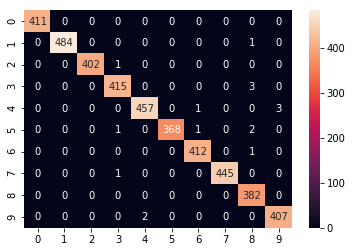

In [23]:


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
sns.heatmap(confusion_mtx, annot=True, fmt='d')


In [24]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [25]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_digit_recog.csv",index=False)

<a href="./cnn_digit_recog.csv"> Download File </a>